In [ ]:
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 6.6 MB/s eta 0:00:00


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    16002
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4000

Total number of variables............................:     6002
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4002
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0000000e+12 2.00e+01 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

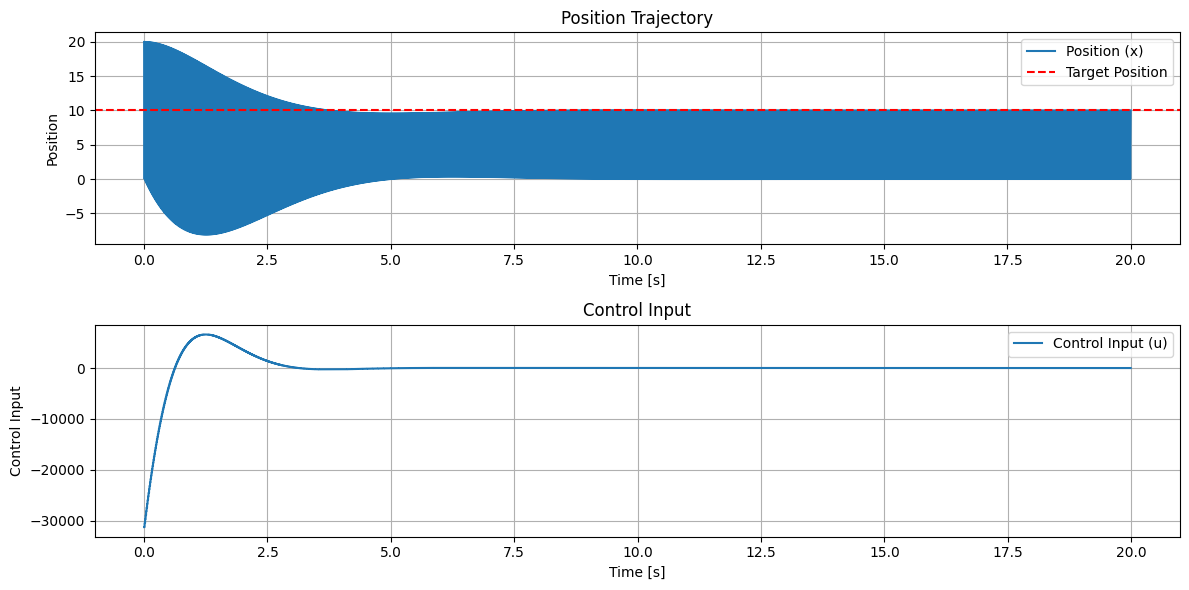

In [69]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# System parameters
m = 1000  # mass
n = 0.5  # damping coefficient
k = 1.0  # spring constant
T = 20.0  # total simulation time
N = 2000  # number of time steps
dt = T / N  # time step duration

# Target position
x0_target = 10.0  # Desired position (trajectory tracking target)

# Cost weights
Q = 10000000  # Position error weight
R = 1  # Control effort weight

# CasADi symbolic variables
x = ca.MX.sym('x', 2)  # State: [position, velocity]
u = ca.MX.sym('u')     # Control input

# Dynamics: dx/dt = [v; -k/m * x - n/m * v + 1/m * u]
xdot = ca.vertcat(x[1], -k/m * x[0] - n/m * x[1] + 1/m * u)

# Decision variables
X = ca.MX.sym('X', 2, N + 1)  # States over time
U = ca.MX.sym('U', N)         # Control inputs over time

# Objective and constraints
cost = 0
constraints = []

# Initial condition
constraints.append(X[:, 0] - ca.MX([20, 0]))  # Start at rest: x(0) = 0, v(0) = 0

for i in range(N):
    # State and control at time step i
    x_i = X[:, i]
    u_i = U[i]

    # State at next time step
    x_next = X[:, i + 1]

    # Dynamics constraint
    x_next_pred = x_i + dt * ca.mtimes(A, x_i) + dt * ca.mtimes(B, u_i)
    constraints.append(x_next - x_next_pred)

    # Cost function: penalize position error and control effort
    cost += Q * (x_i[0] - x0_target)**2 + R * u_i**2

# Flatten constraints
constraints = ca.vertcat(*constraints)

# Optimization variables
opt_vars = ca.vertcat(ca.reshape(X, -1, 1), U)

# Problem setup
nlp = {
    'x': opt_vars,
    'f': cost,
    'g': constraints
}

# Solver setup
solver = ca.nlpsol('solver', 'ipopt', nlp)

# Initial guess
X_guess = np.zeros((2, N + 1))
U_guess = np.zeros(N)
opt_vars_guess = np.concatenate([X_guess.flatten(), U_guess])

# Bounds
lb_x = -np.inf * np.ones(opt_vars.shape[0])
ub_x = np.inf * np.ones(opt_vars.shape[0])
lb_g = np.zeros(constraints.shape[0])
ub_g = np.zeros(constraints.shape[0])

# Solve
solution = solver(x0=opt_vars_guess, lbx=lb_x, ubx=ub_x, lbg=lb_g, ubg=ub_g)
opt_vars_sol = solution['x'].full().flatten()

# Extract solution
X_sol = opt_vars_sol[:2 * (N + 1)].reshape(2, N + 1)
U_sol = opt_vars_sol[2 * (N + 1):]

# Plot results
time = np.linspace(0, T, N + 1)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, X_sol[0, :], label="Position (x)")
plt.axhline(x0_target, color='r', linestyle='--', label="Target Position")
plt.title("Position Trajectory")
plt.xlabel("Time [s]")
plt.ylabel("Position")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.step(time[:-1], U_sol, where='post', label="Control Input (u)")
plt.title("Control Input")
plt.xlabel("Time [s]")
plt.ylabel("Control Input")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


<ipython-input-71-bf26963f0bc7>:11: RuntimeWarning: overflow encountered in exp
  return a * np.sin(b * x + c) * np.exp(-d * x) + x0
<ipython-input-71-bf26963f0bc7>:11: RuntimeWarning: overflow encountered in multiply
  return a * np.sin(b * x + c) * np.exp(-d * x) + x0


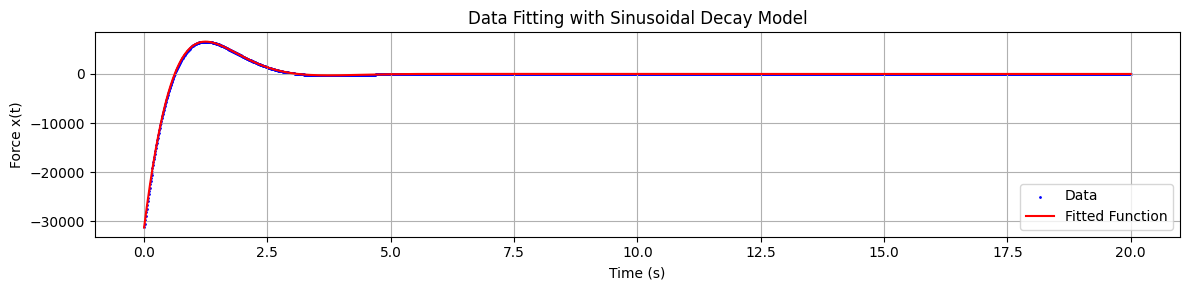

Fitted Parameters: [-4.44325703e+04  1.25683620e+00 -1.64869897e+01  1.25662418e+00
  9.52126969e+00]


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Generate example data
x_data = np.linspace(0, 20, 2000)
y_data = np.array(U_sol)

# Define the model function
def model(x, a, b, c, d, x0):
    return a * np.sin(b * x + c) * np.exp(-d * x) + x0

# Initial guesses for parameters
initial_guess = [0.5, 2 * np.pi, 0.0, 0.1, 0.5]

# Fit the model to the data
try:
    params, params_covariance = curve_fit(model, x_data, y_data, p0=initial_guess, maxfev=10000)
except RuntimeError as e:
    print(f"Curve fit failed: {e}")
    params = initial_guess  # Use the initial guess as a fallback
func = model(x_data, *params)
# Plot the data and the fitted function
plt.figure(figsize=(12, 3))
plt.scatter(x_data, y_data, label="Data", color="blue", s=1)
plt.plot(x_data, model(x_data, *params) , label="Fitted Function", color="red")
plt.legend()
plt.title("Data Fitting with Sinusoidal Decay Model")
plt.xlabel("Time (s)")
plt.ylabel("Force x(t)")
plt.grid()
plt.tight_layout()
plt.show()
list1 = list(params)
print("Fitted Parameters:", params)


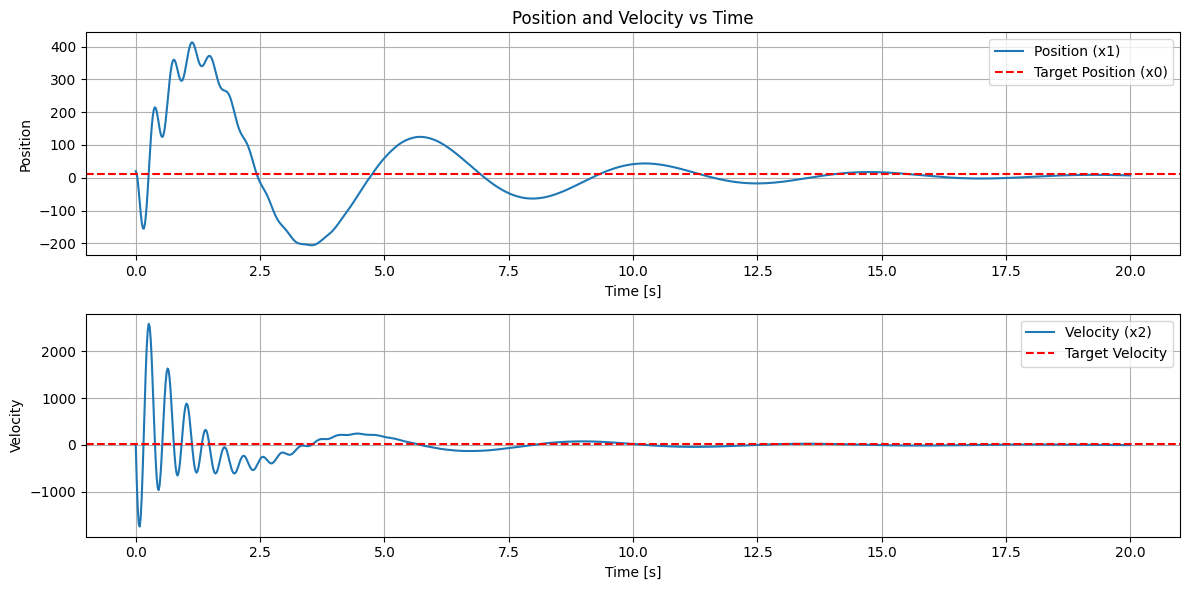

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
m = 1.0  # Mass
n = 0.5  # Damping coefficient
k = 2.0  # Spring constant
T = 20.0  # Total simulation time
x0 = [20, 0]  # Initial condition: [position, velocity]

# Control input u(t) (replace this with your fitted model)
def u(t):
    A, B, D, E, F = list1
    return A * np.exp(-B * t) * np.sin(D * t + E) + F

# System dynamics as a first-order ODE
def dynamics(t, y):
    x1, x2 = y  # y[0]: position, y[1]: velocity
    dx1_dt = x2
    dx2_dt = (u(t) - n * x2 - k * x1) / m
    return [dx1_dt, dx2_dt]

# Time span for the simulation
t_span = (0, T)
t_eval = np.linspace(0, T, 1000)  # Time points for solution evaluation

# Solve the ODE
solution = solve_ivp(dynamics, t_span, x0, t_eval=t_eval, method='RK45')

# Extract the results
time = solution.t
position = solution.y[0]
velocity = solution.y[1]

# Plot the results
plt.figure(figsize=(12, 6))

# Position plot
plt.subplot(2, 1, 1)
plt.plot(time, position, label="Position (x1)")
plt.axhline(10.0, color='r', linestyle='--', label="Target Position (x0)")
plt.title("Position and Velocity vs Time")
plt.xlabel("Time [s]")
plt.ylabel("Position")
plt.legend()
plt.grid()

# Velocity plot
plt.subplot(2, 1, 2)
plt.plot(time, velocity, label="Velocity (x2)")
plt.axhline(10.0, color='r', linestyle='--', label="Target Velocity")
plt.xlabel("Time [s]")
plt.ylabel("Velocity")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
